In [1]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')

In [221]:
import math
from tqdm import tqdm
from torch import Tensor
from typing import Tuple, List


def get_color(x: float, y: float, image: Tensor):
    """
    Selects a color from an image using bilinear interpolation
    """
    i, j = math.floor(y.item()), math.floor(x.item())
    c0 = image[max(i, 0)][max(j, 0)]
    c1 = image[max(i, 0)][min(j+1, image.shape[1] - 1)]
    c2 = image[min(i+1, image.shape[0] - 1)][min(j+1, image.shape[1] - 1)]
    c3 = image[min(i+1, image.shape[0] - 1)][max(j, 0)]
    w_top = y - i
    w_left = x - j
    
    # Step 1: interpolate along x-axis
    color_top = c0 * (1 - w_left) + c1 * w_left
    color_bot = c3 * (1 - w_left) + c2 * w_left
    
    # Step 2: interpolate along y-axis
    color = color_top * (1 - w_top) + w_top * color_bot
    
    return color


def compute_gaussian_density(x: Tuple[float, float], mean: Tuple[float, float], std: Tuple[float, float]):
    exp_term = torch.exp(-0.5 * (((x[0] - mean[0]) / std[0]) ** 2 + ((x[1] - mean[1]) / std[1]) ** 2))
    std_term = 1 / (std[0] * std[1])
    const_term = 1 / (2 * np.pi)
    
    return exp_term * std_term * const_term


def gaussian_interpolation(means: Tensor, stds: Tensor, img: Tensor, radius: int):
    """
    Performs a gaussian process interpolation
    means: [num_coords, 2]
    stds: [num_coords, 2]
    images: [image_width, image_height]
    density_threshold --- we do not 
    """
    colors = torch.zeros_like(img)
    total_weights = torch.zeros(img.shape[0], img.shape[1])

    for i in tqdm(range(0, len(means))):
        center = (round(means[i][0].item()), round(means[i][1].item()))
        color = get_color(means[i][0], means[i][1], img)

        for y_shift in range(-radius, radius + 1):
            for x_shift in range(-radius, radius + 1):
                pixel_pos = (center[0] + x_shift, center[1] + y_shift)
                
                if (pixel_pos[0] < 0 or pixel_pos[0] >= img.shape[1]) or (pixel_pos[1] < 0 or pixel_pos[1] >= img.shape[0]):
                    continue

                weight = compute_gaussian_density(pixel_pos, means[i], stds[i])
                #weight = (1 / ((pixel_pos[0] - means[i][0]) ** 2 + (pixel_pos[1] - means[i][1]) ** 2 + 1e-10)) ** 1

                if weight > 0:
                    colors[pixel_pos[1], pixel_pos[0]] += color * weight
                    total_weights[pixel_pos[1], pixel_pos[0]] += weight
    
    # Now, we should normalize the colors by the total weight
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if total_weights[i][j] > 0:
                colors[i][j] /= total_weights[i][j]

    return colors, total_weights


100%|██████████| 50/50 [00:01<00:00, 41.07it/s]


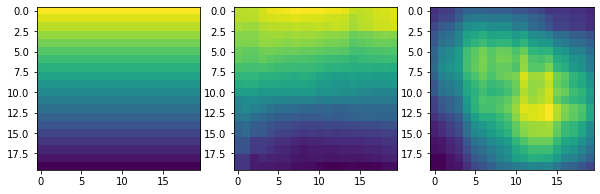

In [179]:
size = 20
grid_size = size // 2
num_points = (grid_size ** 2) // 2
img = torch.linspace(1, 0, size).view(-1, 1).repeat(1, size).unsqueeze(2)
# x_coords = torch.tensor([0.0, 1.5, 3.0]).view(1, -1).repeat(3, 1).float()
# coords = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0)
# img = torch.linspace(0, 1, 2).view(-1, 1).repeat(1, 2).unsqueeze(2)
# x_coords = torch.tensor([0.0, 1.0]).view(1, -1).repeat(2, 1).float()
# coords = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0)
means = torch.rand(num_points, 2) * size
#stds = torch.rand(num_points, 1).view(-1, 1).repeat(1, 2) * 10.0
stds = torch.ones(num_points, 1).view(-1, 1).repeat(1, 2) * 5.0
# means = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
# stds = torch.rand(4, 2) * 1.0
result, weights = gaussian_interpolation(means, stds, img, 5)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.imshow(img.squeeze(2))

plt.subplot(132)
plt.imshow(result.squeeze(2))

plt.subplot(133)
plt.imshow(weights)

In [222]:
import torch.nn as nn
import torchvision.transforms.functional as TVF

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png').convert('LA')
img = TVF.to_grayscale(img)
img = torch.from_numpy(np.array(img)).unsqueeze(2)
img_size = img.shape[0]
grid_size = img_size // 4
x_coords = torch.linspace(0.0, img_size - 1, grid_size).view(1, -1).repeat(grid_size, 1).float()
means = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0).view(-1, 2)
stds = torch.ones_like(coords) * 1.0

means = nn.Parameter(means)
stds = nn.Parameter(stds)
result, weights = gaussian_interpolation(means, stds, img.float(), 5)
# result = result.permute(2, 0, 1).byte()

100%|██████████| 1024/1024 [00:31<00:00, 32.67it/s]


In [225]:
diff = (result - img.float())

In [227]:
loss = diff.abs().mean()

In [229]:
loss.backward()

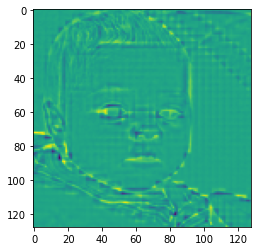

In [238]:
plt.imshow((diff / diff.abs().max() + 1).detach().squeeze(2) * 0.5)

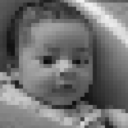

In [240]:
TVF.to_pil_image(result.permute(2, 0, 1).byte())

In [247]:
means_adjusted = means - means.grad * 0.5
stds_adjusted = stds - stds.grad * 0.5
result_adjusted, _ = gaussian_interpolation(means_adjusted.detach(), stds_adjusted.detach(), img.float(), 5)

100%|██████████| 1024/1024 [00:22<00:00, 44.53it/s]


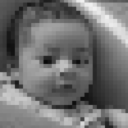

In [248]:
TVF.to_pil_image(result_adjusted.permute(2, 0, 1).byte())

In [249]:
(result_adjusted - img.float()).abs().mean()

tensor(7.5882)

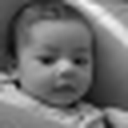

In [207]:
TVF.resize(TVF.resize(TVF.to_pil_image(img.permute(2,0,1).byte()), size=(grid_size,grid_size), interpolation=4), size=(128,128), interpolation=1)

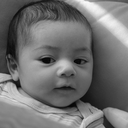

In [219]:
TVF.to_pil_image(img.permute(2, 0, 1))